# Covtype dataset

In [1]:
import time

import pandas as pd
from river import (
    ensemble,
    evaluate,
    linear_model,
    metrics,
    multiclass,
    neighbors,
    preprocessing,
    stream,
    tree,
    utils,
)
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import AutoMinorLocator

Columns header to add at the top of the data file:

In [2]:
columns_name = (
    [
        "Elevation",
        "Aspect",
        "Slope",
        "Horizontal_Distance_To_Hydrology",
        "Vertical_Distance_To_Hydrology",
        "Horizontal_Distance_To_Roadways",
        "Hillshade_9am",
        "Hillshade_Noon",
        "Hillshade_3pm",
        "Horizontal_Distance_To_Fire_Points",
    ]
    + [f"Wilderness_Area_{i}" for i in range(1, 5)]
    + [f"Soil_Type_{i}" for i in range(1, 41)]
    + ["Cover_Type"]
)

print(",".join(columns_name))

Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Wilderness_Area_4,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type


In [3]:
DATAPATH = "data/covtype.data"
DATAKEY = "covtype"

In [4]:
with open(DATAPATH) as f:
    N_observations = sum(1 for line in f)
N_observations -= 1
print(f"Number of observations : {N_observations}")

Number of observations : 581012


In [5]:
converters = {column: int for column in columns_name}

dataset = stream.iter_csv(DATAPATH, target="Cover_Type", converters=converters)
x, y = next(iter(dataset))
x, y

({'Elevation': 2596,
  'Aspect': 51,
  'Slope': 3,
  'Horizontal_Distance_To_Hydrology': 258,
  'Vertical_Distance_To_Hydrology': 0,
  'Horizontal_Distance_To_Roadways': 510,
  'Hillshade_9am': 221,
  'Hillshade_Noon': 232,
  'Hillshade_3pm': 148,
  'Horizontal_Distance_To_Fire_Points': 6279,
  'Wilderness_Area_1': 1,
  'Wilderness_Area_2': 0,
  'Wilderness_Area_3': 0,
  'Wilderness_Area_4': 0,
  'Soil_Type_1': 0,
  'Soil_Type_2': 0,
  'Soil_Type_3': 0,
  'Soil_Type_4': 0,
  'Soil_Type_5': 0,
  'Soil_Type_6': 0,
  'Soil_Type_7': 0,
  'Soil_Type_8': 0,
  'Soil_Type_9': 0,
  'Soil_Type_10': 0,
  'Soil_Type_11': 0,
  'Soil_Type_12': 0,
  'Soil_Type_13': 0,
  'Soil_Type_14': 0,
  'Soil_Type_15': 0,
  'Soil_Type_16': 0,
  'Soil_Type_17': 0,
  'Soil_Type_18': 0,
  'Soil_Type_19': 0,
  'Soil_Type_20': 0,
  'Soil_Type_21': 0,
  'Soil_Type_22': 0,
  'Soil_Type_23': 0,
  'Soil_Type_24': 0,
  'Soil_Type_25': 0,
  'Soil_Type_26': 0,
  'Soil_Type_27': 0,
  'Soil_Type_28': 0,
  'Soil_Type_29': 1,
  

In [6]:
dataset = stream.iter_csv(DATAPATH, target="Cover_Type", converters=converters)
cache = stream.Cache()
cache.clear_all()

In [7]:
def test_model(
    model, model_name, n_wait=1000, old_df_final_metrics=None, old_df_all_metrics=None
):

    # Define metrics
    acc = metrics.Accuracy()
    acc_roll = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    balanced_acc = metrics.BalancedAccuracy()
    balanced_acc_roll = utils.Rolling(metrics.BalancedAccuracy(), window_size=n_wait)
    f1 = metrics.WeightedF1()
    f1_roll = utils.Rolling(metrics.WeightedF1(), window_size=n_wait)
    # report = metrics.ClassificationReport()
    # report_rolling = utils.Rolling(metrics.ClassificationReport(), window_size=n_wait)

    raw_metrics = []

    t1 = time.time()
    # evaluate.progressive_val_score(cache(dataset, key="key"), model, report)
    for i, (x, y) in tqdm(enumerate(cache(dataset, key=DATAKEY)), total=N_observations):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        # if y_pred is not None:
        acc.update(y, y_pred)
        acc_roll.update(y, y_pred)
        balanced_acc.update(y, y_pred)
        balanced_acc_roll.update(y, y_pred)
        f1.update(y, y_pred)
        f1_roll.update(y, y_pred)
        # report.update(y, y_pred)
        # report_rolling.update(y, y_pred)
        if i % n_wait == 0 and i > 0:
            raw_metrics.append(
                [
                    model_name,
                    i,
                    acc.get(),
                    balanced_acc.get(),
                    f1.get(),
                    acc_roll.get(),
                    balanced_acc_roll.get(),
                    f1_roll.get(),
                ]
            )
        # Learn
        model.learn_one(x, y)
    t2 = time.time()

    df_final_metrics = [
        {
            "classifier": model_name,
            "accuracy": acc.get(),
            "balanced_accuracy": balanced_acc.get(),
            "weighted_f1": f1.get(),
            "time": t2 - t1,
        }
    ]
    df_final_metrics = pd.DataFrame(df_final_metrics).set_index("classifier")

    if old_df_final_metrics is not None:
        df_merge_final_metrics = pd.concat(
            [
                old_df_final_metrics,
                df_final_metrics[
                    ~df_final_metrics.index.isin(old_df_final_metrics.index)
                ],
            ]
        )
        df_merge_final_metrics.update(df_final_metrics)
        df_final_metrics = df_merge_final_metrics

    df_all_metrics = pd.DataFrame(
        raw_metrics,
        columns=[
            "classifier",
            "id",
            "accuracy",
            "balanced_accuracy",
            "weighted_f1",
            "accuracy_roll",
            "balanced_accuracy_roll",
            "weighted_f1_roll",
        ],
    ).set_index(["classifier", "id"])

    if old_df_all_metrics is not None:
        df_merge_all_metrics = pd.concat(
            [
                old_df_all_metrics,
                df_all_metrics[~df_all_metrics.index.isin(old_df_all_metrics.index)],
            ]
        )
        df_merge_all_metrics.update(df_all_metrics)
        df_all_metrics = df_merge_all_metrics

    return df_final_metrics, df_all_metrics


def display_metrics(df_metrics):
    return (
        df_metrics.style.background_gradient(cmap="RdYlGn")
        .background_gradient(cmap="RdYlGn_r", subset=["time"])
        .format(precision=3)
    )

## 1. HoeffdingTreeClassifier

In [8]:
model = tree.HoeffdingTreeClassifier()

df_final_metrics, df_all_metrics = test_model(model, "HoeffdingTreeClassifier")
display_metrics(df_final_metrics)

  0%|          | 0/581012 [00:00<?, ?it/s]

,accuracy,balanced_accuracy,weighted_f1,time
classifier,,,,
HoeffdingTreeClassifier,0.761,0.509,0.756,134.083


## 2. AdaptiveRandomForestClassifier

In [9]:
model = ensemble.AdaptiveRandomForestClassifier(seed=0)

df_final_metrics, df_all_metrics = test_model(
    model,
    "AdaptiveRandomForestClassifier",
    old_df_final_metrics=df_final_metrics,
    old_df_all_metrics=df_all_metrics,
)
display_metrics(df_final_metrics)

  0%|          | 0/581012 [00:00<?, ?it/s]

,accuracy,balanced_accuracy,weighted_f1,time
classifier,,,,
HoeffdingTreeClassifier,0.761,0.509,0.756,134.083
AdaptiveRandomForestClassifier,0.871,0.638,0.869,684.078


## 3. AdaBoostClassifier

In [10]:
model = ensemble.AdaBoostClassifier(
    model=(
        tree.HoeffdingTreeClassifier(
            split_criterion="gini", delta=1e-5, grace_period=2000
        )
    ),
    n_models=5,
    seed=0,
)

df_final_metrics, df_all_metrics = test_model(
    model,
    "AdaBoostClassifier",
    old_df_final_metrics=df_final_metrics,
    old_df_all_metrics=df_all_metrics,
)
display_metrics(df_final_metrics)

  0%|          | 0/581012 [00:00<?, ?it/s]

,accuracy,balanced_accuracy,weighted_f1,time
classifier,,,,
HoeffdingTreeClassifier,0.761,0.509,0.756,134.083
AdaptiveRandomForestClassifier,0.871,0.638,0.869,684.078
AdaBoostClassifier,0.825,0.602,0.824,783.269


## 4. KNNClassifier

In [11]:
model = neighbors.KNNClassifier(window_size=25)

df_final_metrics, df_all_metrics = test_model(
    model,
    "KNNClassifier",
    old_df_final_metrics=df_final_metrics,
    old_df_all_metrics=df_all_metrics,
)
display_metrics(df_final_metrics)

  0%|          | 0/581012 [00:00<?, ?it/s]

,accuracy,balanced_accuracy,weighted_f1,time
classifier,,,,
HoeffdingTreeClassifier,0.761,0.509,0.756,134.083
AdaptiveRandomForestClassifier,0.871,0.638,0.869,684.078
AdaBoostClassifier,0.825,0.602,0.824,783.269
KNNClassifier,0.949,0.778,0.949,205.665


## 5. LogisticRegression

In [12]:
model = preprocessing.StandardScaler() | multiclass.OneVsOneClassifier(
    linear_model.LogisticRegression()
)

df_final_metrics, df_all_metrics = test_model(
    model,
    "LogisticRegression",
    old_df_final_metrics=df_final_metrics,
    old_df_all_metrics=df_all_metrics,
)
display_metrics(df_final_metrics)

  0%|          | 0/581012 [00:00<?, ?it/s]

,accuracy,balanced_accuracy,weighted_f1,time
classifier,,,,
HoeffdingTreeClassifier,0.761,0.509,0.756,134.083
AdaptiveRandomForestClassifier,0.871,0.638,0.869,684.078
AdaBoostClassifier,0.825,0.602,0.824,783.269
KNNClassifier,0.949,0.778,0.949,205.665
LogisticRegression,0.869,0.701,0.868,120.764


## 6. Plots

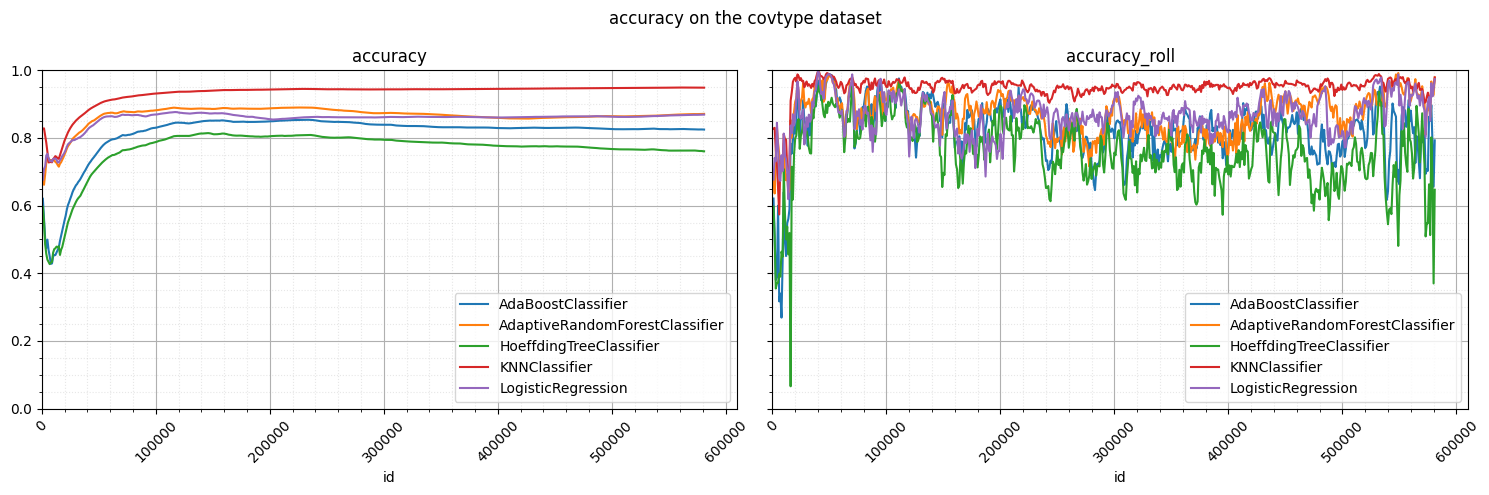

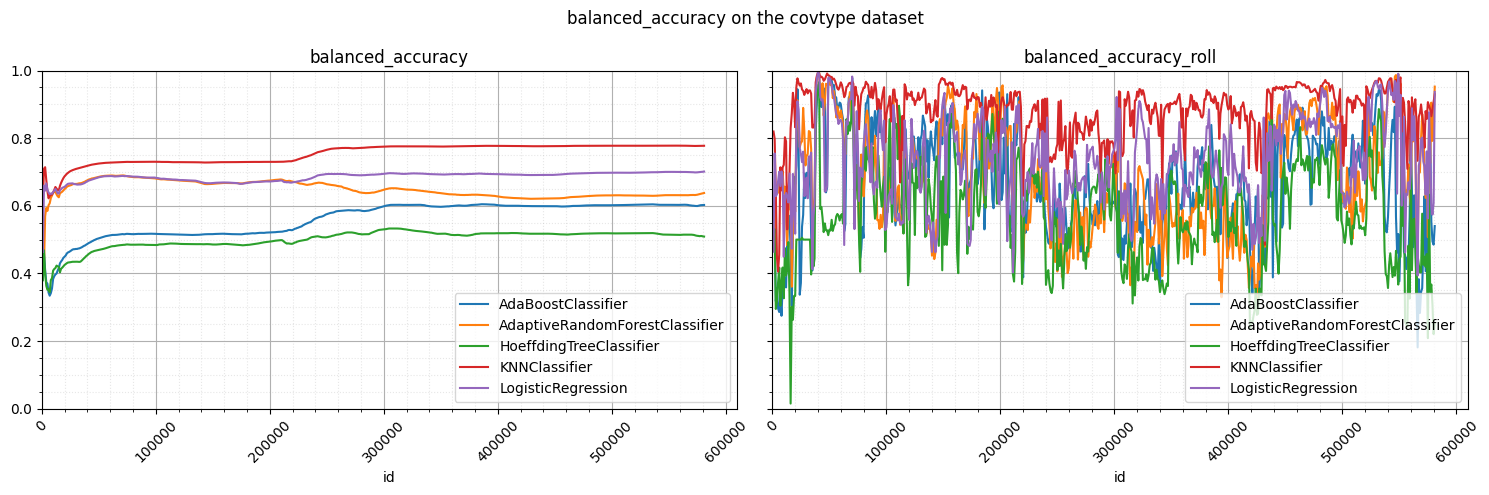

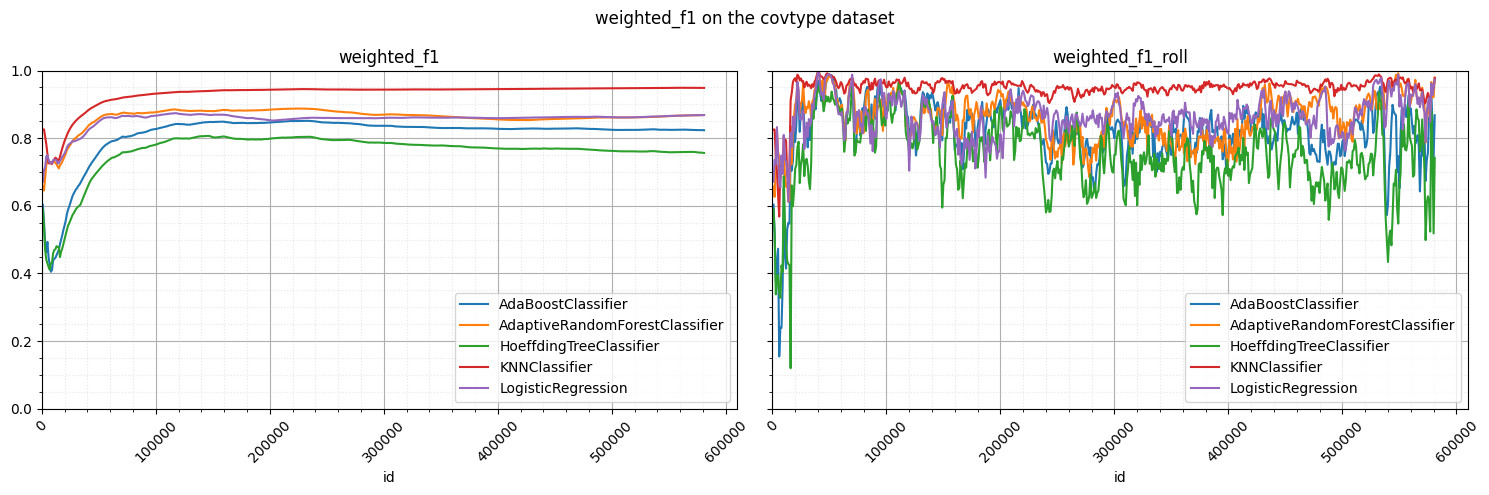

In [13]:
grouped = df_all_metrics.reset_index().set_index("id").groupby("classifier")

for METRIC in ["accuracy", "balanced_accuracy", "weighted_f1"]:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=True)
    for metric, ax in zip([METRIC, METRIC + "_roll"], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)

        ax.legend(loc="lower right")
        ax.set_ylim(0, 1)
        ax.set_xlim(0, None)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.grid(which="major")
        ax.grid(which="minor", axis="x", linestyle=":", alpha=0.3)
        ax.grid(which="minor", axis="y", linestyle=":", alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"pdf/results_{DATAKEY}_{METRIC}.pdf")

    fig.suptitle(f"{METRIC} on the {DATAKEY} dataset")
    plt.tight_layout()
    plt.show()

In [14]:
cache.clear_all()